In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Access folder in Google Drive
folder_path = '/content/drive/MyDrive/Machine Learning Projects/Depression Analysis'
os.chdir(folder_path)

Mounted at /content/drive


In [ ]:
!pip  install transformers
!pip install tensorflow

In [ ]:
from transformers import RobertaTokenizer
from transformers import TFRobertaForSequenceClassification
from transformers import TextClassificationPipeline
import numpy as np

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/datasets/d1_preprocessed_balanced_dataset.csv')

In [ ]:
df.head()

,level,count,preprocessed_text
0,Moderate,11,So apparently I 've been diagnosed with Depres...
1,Severe,23,@ Sarah K Silver man I never meant to like T a...
2,Severe,22,I was diagnosed with depression general ized a...
3,Moderate,24,I was diagnosed with rapid cycling # b ipolar ...
4,Moderate,22,@ Beyond AD HD @ Dr Sus annah I was diagnosed ...


In [ ]:
df.shape

(8289, 3)

## Encoding the levels

In [ ]:
df['level'].unique()

array(['Moderate', 'Severe', 'Mild'], dtype=object)

In [ ]:
df['encoded_text'] = df['level'].astype('category').cat.codes

df.head(10)

,level,count,preprocessed_text,encoded_text
0,Moderate,11,So apparently I 've been diagnosed with Depres...,1
1,Severe,23,@ Sarah K Silver man I never meant to like T a...,2
2,Severe,22,I was diagnosed with depression general ized a...,2
3,Moderate,24,I was diagnosed with rapid cycling # b ipolar ...,1
4,Moderate,22,@ Beyond AD HD @ Dr Sus annah I was diagnosed ...,1
5,Severe,20,Not only depression I was diagnosed with sever...,2
6,Severe,23,So I have been diagnosed with clinical depress...,2
7,Mild,24,Conf ession 29 i have been diagnosed of depres...,0
8,Mild,21,I was 19 years old when I was diagnosed w clin...,0
9,Moderate,23,Apparently I 've been diagnosed with clinical ...,1


In [ ]:
data_texts = df['preprocessed_text'].to_list()

data_labels = df['encoded_text'].to_list()

## Train Test SPlit

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

test_encodings = tokenizer(test_texts, truncation = True, padding = True )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

## Fine-tuning with the TFTrainer class

In [ ]:
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
# Define the hyperparameters for training
batch_size = 16
num_epochs = 10
learning_rate = 3e-5

In [ ]:
# Create the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Define the metrics to track during training
metrics = ['accuracy']

In [ ]:
# Compile the model with the optimizer, loss, and metrics
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = model.fit(train_dataset.batch(batch_size), epochs=num_epochs)

Epoch 1/10
415/415 [==============================] - 124s 300ms/step - loss: 0.0518 - accuracy: 0.9825
Epoch 2/10
415/415 [==============================] - 122s 294ms/step - loss: 0.0526 - accuracy: 0.9830
Epoch 3/10
415/415 [==============================] - 121s 292ms/step - loss: 0.0407 - accuracy: 0.9882
Epoch 4/10
415/415 [==============================] - 121s 293ms/step - loss: 0.0363 - accuracy: 0.9893
Epoch 5/10
415/415 [==============================] - 122s 293ms/step - loss: 0.0425 - accuracy: 0.9863
Epoch 6/10
415/415 [==============================] - 121s 292ms/step - loss: 0.0469 - accuracy: 0.9860
Epoch 7/10
415/415 [==============================] - 122s 293ms/step - loss: 0.0411 - accuracy: 0.9878
Epoch 8/10
415/415 [==============================] - 122s 293ms/step - loss: 0.0356 - accuracy: 0.9888
Epoch 9/10
415/415 [==============================] - 122s 293ms/step - loss: 0.0316 - accuracy: 0.9906
Epoch 10/10
415/415 [==============================] - 122s 293m

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset.batch(batch_size))
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

104/104 [==============================] - 14s 105ms/step - loss: 0.4591 - accuracy: 0.8987
Test loss: 0.4591046869754791
Test accuracy: 0.8986731171607971


In [ ]:
# Get the predicted labels for the test dataset
y_pred = np.argmax(model.predict(test_dataset.batch(batch_size)).logits, axis=1)

104/104 [==============================] - 13s 101ms/step


In [ ]:
# Print the classification report with precision, recall, and F1 score
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       535
           1       0.84      0.88      0.86       570
           2       0.89      0.85      0.87       553

    accuracy                           0.90      1658
   macro avg       0.90      0.90      0.90      1658
weighted avg       0.90      0.90      0.90      1658



## Confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate a confusion matrix based on the classification report
labels = list(set(test_labels + y_pred))
cm = confusion_matrix(test_labels, y_pred, labels=labels)

Confusion matrix, without normalization


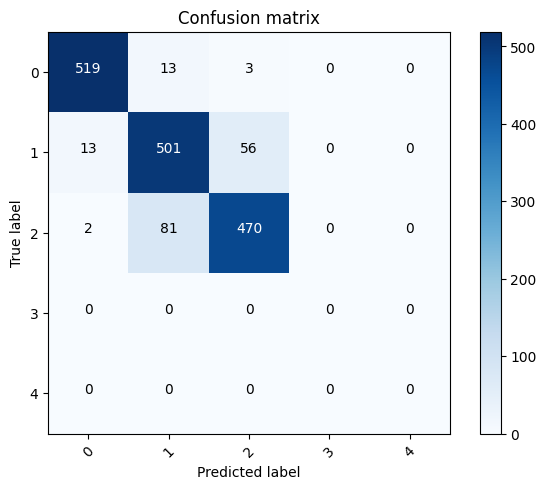

In [ ]:
# Define a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, labels, normalize=False, title='Confusion matrix')
plt.show()

# Saving & Loading the mode

In [ ]:
save_directory = "/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model"

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model/vocab.json',
 '/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model/merges.txt',
 '/content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model/added_tokens.json')

# Loading Pre-Trained Model

In [ ]:
tokenizer_fine_tuned = RobertaTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFRobertaForSequenceClassification.from_pretrained(save_directory)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Machine Learning Projects/Depression Analysis/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
test_text = test_texts[0]

test_text

"@ ste ve turn er 02 @ S ally B erc ow If depression is class ed as a legal excuse I 'll be ok for my next @ At os gr illing then as I 'm diagnosed with it"

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

0